<a href="https://colab.research.google.com/github/Fireow9039/Direct-Policy-Search-PPO-Algorithm-Actor-Critic-Methods-/blob/main/NN%2BRL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, LogisticRegression
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Layer
from tensorflow.keras.initializers import GlorotNormal, Constant
from tensorflow.keras.optimizers import Adam

In [ ]:
def load_and_prepare_data():
    data = load_breast_cancer()
    X = pd.DataFrame(data.data, columns=data.feature_names)
    y = pd.Series(data.target)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled, y.values, list(data.feature_names)

In [ ]:
class ConcreteSelector(Layer):
    def __init__(self, output_dim, start_temp=10.0, min_temp=0.1):
        super(ConcreteSelector, self).__init__()
        self.output_dim = output_dim
        self.start_temp = start_temp
        self.min_temp = min_temp

    def build(self, input_shape):
      self.temp = self.add_weight(name="temp", shape=(), initializer=Constant(self.start_temp), trainable=False)
      self.logits = self.add_weight(name="logits", shape=(self.output_dim, input_shape[-1]), initializer=GlorotNormal(), trainable=True)

    def call(self, X, training=True):
        uniform = tf.random.uniform(shape=tf.shape(self.logits), minval=1e-10, maxval=1.0)
        gumbel_noise = -tf.math.log(-tf.math.log(uniform))
        noisy_logits = (self.logits + gumbel_noise) / tf.maximum(self.min_temp, self.temp)
        soft_samples = tf.nn.softmax(noisy_logits, axis=-1)
        selected_features = tf.matmul(X, tf.transpose(soft_samples))
        return selected_features, soft_samples

In [ ]:
def build_policy_network(input_dim):
    inputs = Input(shape=(input_dim,))
    x = Dense(32, activation='relu')(inputs)
    x = Dense(32, activation='relu')(x)
    outputs = Dense(input_dim, activation='sigmoid')(x)
    return Model(inputs, outputs)

In [ ]:
def build_classifier(input_dim):
    inputs = Input(shape=(input_dim,))
    x = Dense(64, activation='relu')(inputs)
    x = Dense(32, activation='relu')(x)
    outputs = Dense(2, activation='softmax')(x)
    return Model(inputs, outputs)

In [ ]:
def compute_reward(y_true, y_pred, mask, alpha=0.01):
    acc = accuracy_score(y_true, y_pred)
    selected_features = np.sum(mask)
    total_features = len(mask)
    penalty = alpha * (selected_features / total_features)
    return acc - penalty

In [ ]:
def visualize_weights(weights, feature_names):
    mean_weights = np.mean(weights, axis=0)
    top_indices = np.argsort(-mean_weights)[:10]
    plt.figure(figsize=(10, 4))
    sns.barplot(x=[feature_names[i] for i in top_indices], y=mean_weights[top_indices])
    plt.title("Top 10 Feature Importance")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

In [ ]:
def train_feature_selector_rl(X, y, feature_names, num_epochs=50, policy_epochs=25):
    input_dim = X.shape[1]
    selector = ConcreteSelector(output_dim=input_dim)
    classifier = build_classifier(input_dim)
    policy_net = build_policy_network(input_dim)

    optimizer_selector = Adam(learning_rate=0.01)
    optimizer_policy = Adam(learning_rate=0.005)
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

    # Pre-train selector
    for epoch in range(num_epochs):
        with tf.GradientTape() as tape:
            X_input = tf.convert_to_tensor(X, dtype=tf.float32)
            selected, weights = selector(X_input, training=True)
            recon = tf.matmul(selected, selector.logits)
            loss = tf.reduce_mean(tf.square(X_input - recon))
        grads = tape.gradient(loss, selector.trainable_variables)
        optimizer_selector.apply_gradients(zip(grads, selector.trainable_variables))

    # Train with RL
    rewards = []
    for epoch in range(policy_epochs):
        X_input = tf.convert_to_tensor(X, dtype=tf.float32)
        selected_features, weights = selector(X_input, training=False)

        probs = policy_net(selected_features)
        masks = tf.cast(probs > 0.5, tf.float32).numpy()
        X_masked = X_input.numpy() * masks

        clf = build_classifier(input_dim)
        clf.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        clf.fit(X_masked, y, epochs=10, verbose=0)
        y_pred = np.argmax(clf.predict(X_masked), axis=1)

        reward = compute_reward(y, y_pred, masks[0])
        rewards.append(reward)

        with tf.GradientTape() as tape:
            policy_out = policy_net(selected_features)
            loss = -tf.reduce_mean(tf.convert_to_tensor(reward, dtype=tf.float32) * tf.math.log(policy_out + 1e-8))
        grads = tape.gradient(loss, policy_net.trainable_variables)
        optimizer_policy.apply_gradients(zip(grads, policy_net.trainable_variables))

    y_pred = np.argmax(clf.predict(X_masked), axis=1)
    acc = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    print("\n[RL-Based Feature Selector Results]")
    print(f"Accuracy: {acc:.4f}, F1 Score: {f1:.4f}, Reward: {np.mean(rewards):.4f}")
    visualize_weights(weights.numpy(), feature_names)
    return acc, f1

In [ ]:
def lasso_baseline(X, y):
    lasso = LassoCV(cv=5).fit(X, y)
    model = SelectFromModel(lasso, prefit=True)
    X_sel = model.transform(X)
    clf = LogisticRegression(max_iter=1000).fit(X_sel, y)
    y_pred = clf.predict(X_sel)
    acc = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    print("\n[Lasso Baseline Results]")
    return acc, f1

def rfe_baseline(X, y):
    base_model = LogisticRegression(max_iter=1000)
    selector = RFE(base_model, n_features_to_select=5).fit(X, y)
    X_sel = selector.transform(X)
    base_model.fit(X_sel, y)
    y_pred = base_model.predict(X_sel)
    acc = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    print("\n[RFE Baseline Results]")
    return acc, f1

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
18/18 ━━━━━━━━━━━━━━━━━━━

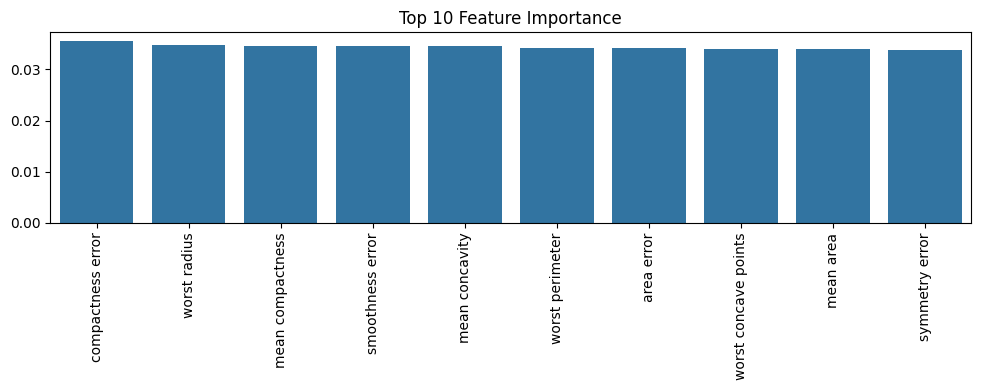

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.020023834778704952, tolerance: 0.00984263736263736
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02352934130620099, tolerance: 0.00984263736263736
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011313444416757079, tolerance: 0.00984263736263736
  model = cd_fast.enet_coordinate_descent_gram(



[Lasso Baseline Results]

[RFE Baseline Results]

--- Final Comparison Table ---
RL Selector     -> Accuracy: 0.9859, F1: 0.9888
Lasso           -> Accuracy: 0.9877, F1: 0.9902
RFE             -> Accuracy: 0.9666, F1: 0.9734


In [ ]:
if __name__ == '__main__':
    X, y, feature_names = load_and_prepare_data()

    acc_rl, f1_rl = train_feature_selector_rl(X, y, feature_names)
    acc_lasso, f1_lasso = lasso_baseline(X, y)
    acc_rfe, f1_rfe = rfe_baseline(X, y)

    print("\n--- Final Comparison Table ---")
    print(f"RL Selector     -> Accuracy: {acc_rl:.4f}, F1: {f1_rl:.4f}")
    print(f"Lasso           -> Accuracy: {acc_lasso:.4f}, F1: {f1_lasso:.4f}")
    print(f"RFE             -> Accuracy: {acc_rfe:.4f}, F1: {f1_rfe:.4f}")